<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/TAAPC_Exercises/week3_RNNs/time_series_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

In this notebook, we will use LSTMs for weather forecasting.

The notebook is based on this TensorFlow tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series. However, here we will use [PyTorch](https://pytorch.org/) to implement our model.

The dataset we use here was recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
import os
import random

import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from tqdm import tqdm

In [ ]:
# Download the data
import requests
import zipfile
response = requests.get('https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip')
open('weather_dataset.zip', 'wb').write(response.content)
with zipfile.ZipFile('weather_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
df = pd.read_csv('jena_climate_2009_2016.csv')

In [ ]:
# Let's take a look at the data frame
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


The dataset contains measurements taken each 10 minutes. We will subsample it to have hourly measurements.

In [ ]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

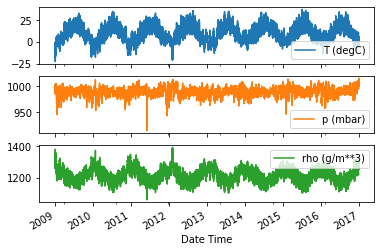

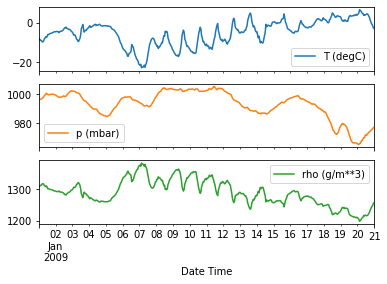

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Let's look at some statistics of our data...

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [ ]:
# Remove invalid values
wv = df['wv (m/s)']
bad_wv = (wv == -9999.0)
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = (max_wv == -9999.0)
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Our dataset contains angular data for the wind direction. However, angles are not suitable representations as model inputs (not that 0 and 360 degrees are the same). Moreover, whenever the wind speed is zero, the wind direction is meaningless.

Therefore, we will use the wind speed and direction to build the corresponding **wind vector**, which will be one of the inputs of our model.

In [ ]:
# Build wind vector
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Date strings are also innapropriate as model inputs. Can you understand the preprocessing we are doing below?

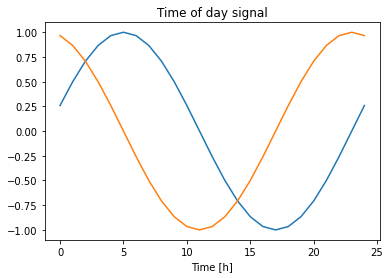

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

**Explain** the preprocessing above in your own words:

The timestamps are intially written in Posix format. The first line maps each Posix string into a float, giving the elapsed time in seconds (w.r.t to some original date).

We then define how many seconds a year corresponds to.

Finally, we map it using a sinusoidal function with a given period. This gives a float between $[-1, 1]$, encoding the time inside inside a day/year the features correspond to.

This is useful since weather data usually looks at parameter variation during a day, and yearly in order to capture seasonality. It is nice to have a representation that assigns the same value for the same hour in different days, etc.

Note that having both $\sin, \cos$ values at the same time allows for an one-to-one mapping. If we used only one component, we wouldn't have an injection and the period would be ambiguous by a factor of 12 hours / 6 months.

Now, we are ready to split our data into train, validation and test splits. We will use the first 70% samples for training, the following 20% for validation and the last 10% for testing.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Note that we are **not** splitting our data randomly. Can you explain why a random split is not a good idea in this case?

If we split randomly a time series, we have data leakage from long-term dynamics that should've developed only in a later portion of it, into the training set.

It is crucial to scale features before feeding them through a neural network. Normalize the data in the cell below by subtracting the mean and dividing by the standard deviation.

You should create the variables `train_mean` and `train_std` and use them to normalize the three data splits.

In [ ]:
## YOUR CODE HERE ##

# Only compute mean/std with training data to avoid data leakage
train_mean = train_df.mean()
train_std = train_df.std()

# Normalize each set
train_df = (train_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std

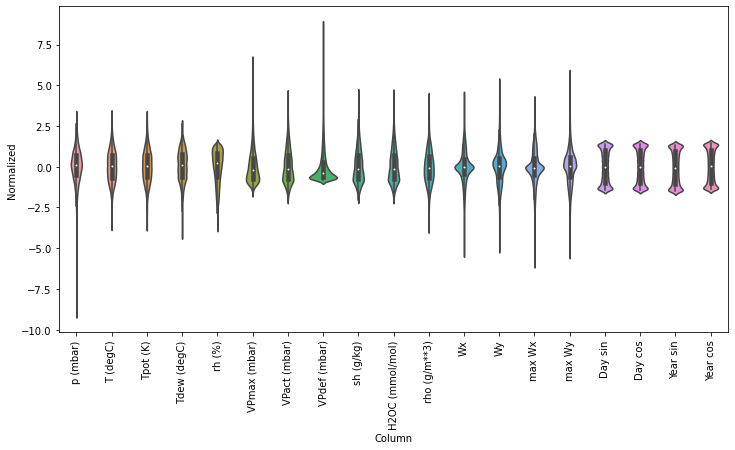

In [ ]:
# Look at normalized data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

The `torch.utils.data.Dataset` class provides a very convenient way of storing and loading data. In the cell below, we define the class `WeatherData`, which inherits from this `Dataset` class. The following functions must be defined within the class:
- `__init__`, where the attributes of the class are defined;
- `__getitem__`, which gets an index (`int`) and returns the data example corresponding to the provided index (can be a `tuple` or a `dict`);
- `__len__`, which returns the length of the dataset.

We have already written the functions `__getitem__` and `__len__` for you. All you need to do is write the code for the `__init__` function. There, you should create two lists as attributes of the class: `inputs` and `targets`. The `i`-th element of the list `inputs` should be a `torch.FloatTensor` containing a slice of the data with `input_width` consecutive samples. The `i`-th element of the list `targets` should be a `torch.FloatTensor` containing a slice of the data with the `target_width` consecutive samples that follow after `inputs[i]`.

In [ ]:
class WeatherData(torch.utils.data.Dataset):
    def __init__(self, df, input_width, target_width):
        ## YOUR CODE HERE ##
        df_arr = np.array(df)
        length = df_arr.shape[0]
        self.inputs = [torch.FloatTensor(df_arr[i:(i+input_width), :]) \
                       for i in range(0, length - input_width, input_width)]
        self.targets = [torch.FloatTensor(df_arr[i:(i+target_width), :]) \
                        for i in range(0, length - input_width, input_width)]

    def __getitem__(self, idx):
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}
    
    def __len__(self):
        return min(len(self.inputs), len(self.targets))

We will use the observations of the previous 24 hours to predict the temperature for the next 24 hours. Thus, we will set both `input_width` and `target_width` to 24 in the instances of the dataset. After you complete this exercise, you can try with different values.

In [ ]:
INPUT_WIDTH = 24
TARGET_WIDTH = 24

train_data = WeatherData(train_df, INPUT_WIDTH, TARGET_WIDTH)
val_data = WeatherData(val_df, INPUT_WIDTH, TARGET_WIDTH)
test_data = WeatherData(test_df, INPUT_WIDTH, TARGET_WIDTH)

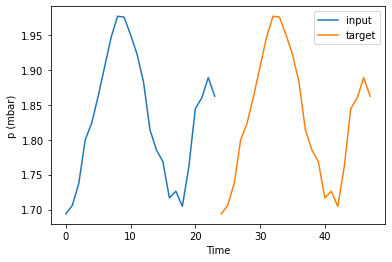

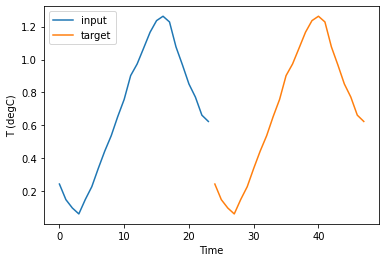

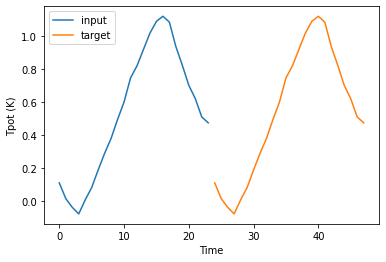

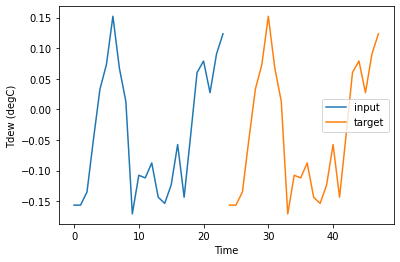

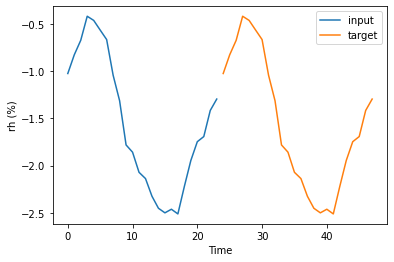

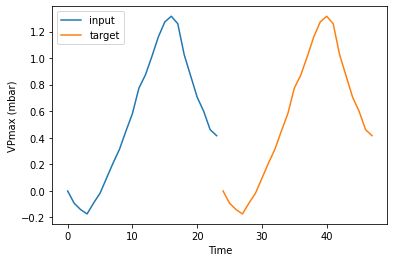

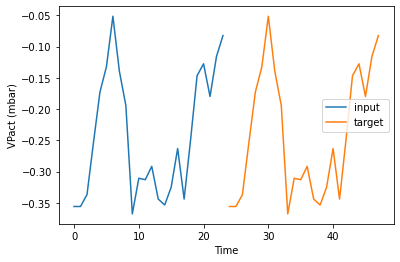

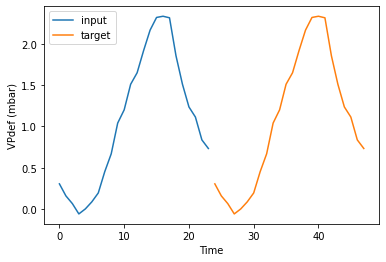

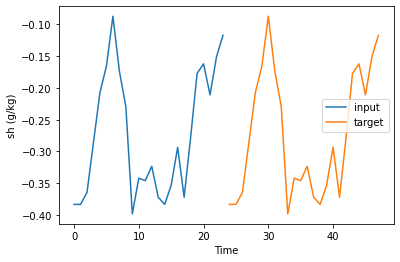

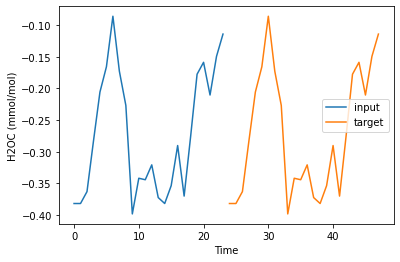

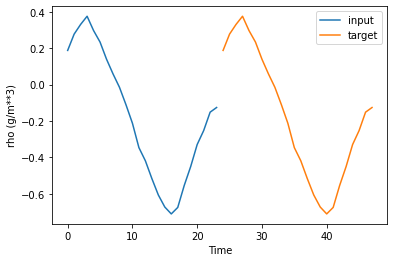

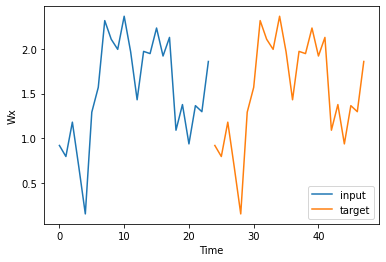

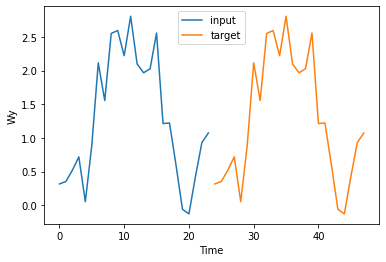

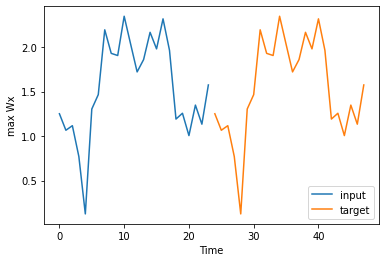

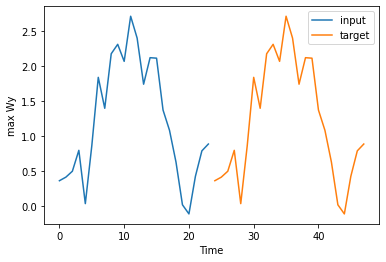

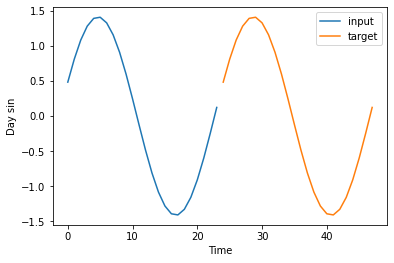

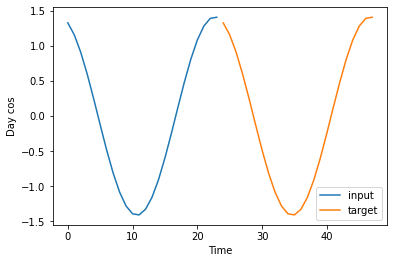

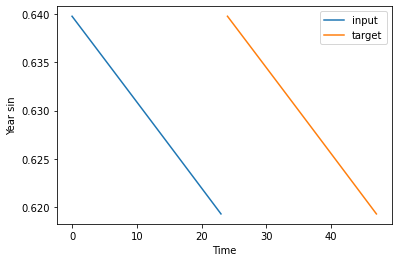

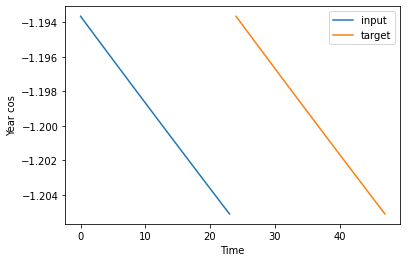

In [ ]:
# Let's visualize some examples
idx = random.randint(0, len(train_data))
inputs = train_data[idx]['inputs'].numpy()
targets = train_data[idx]['targets'].numpy()

for i in range(len(train_df.columns)):
    plt.plot(range(INPUT_WIDTH), inputs[:,i], label='input')
    plt.plot(range(INPUT_WIDTH, INPUT_WIDTH + TARGET_WIDTH), targets[:,i], label='target')
    plt.ylabel(train_df.columns[i])
    plt.xlabel('Time')
    plt.legend()
    plt.show()

Now, it's time to define our neural network! It will consist of a `torch.nn.LSTMCell` with a state dimension defined by `hidden_size`, followed by a `torch.nn.Linear` layer that projects from the hidden space to the output.

The best way to define a neural network in PyTorch is by extending the class `torch.nn.Module`. For this purpose, you need to define two functions:
- `__init__`, where all the layers of the network are instantiated;
- `forward`, where the forward pass is defined.

Complete the two methods in the cell below. The comments throughout the code will provide you some hints.

In [ ]:
class WeatherPredictor(torch.nn.Module):
    def __init__(self, num_features, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # instantiate a torch.nn.LSTMCell and a torch.nn.Linear layer
        
        # hidden_size is the internal state dimension
        # this is a hyperparameter
        self.lstm = torch.nn.LSTMCell(input_size=num_features,
                                      hidden_size=hidden_size)
        self.linear = torch.nn.Linear(in_features=hidden_size,
                                      out_features=num_features)
        
    def forward(self, inputs, num_steps):
        inputs = inputs.swapaxes(0, 1)  # batch, time, dim -> time, batch, dim
        
        # we initialize the internal states of the LSTM with zeros
        ## YOUR CODE HERE ##
        hx = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)
        cx = torch.zeros((inputs.shape[1], self.hidden_size), device=inputs.device)
        
        # warmup: feed the inputs through the LSTM one by one from t = 0 up to t = T-1
        T = inputs.shape[0]
        for t in range(0, T-1):
            hx, cx = self.lstm(inputs[t, :, :], (hx, cx))
        ## *** ##

        # predict num_steps into the future autoregressively
        outputs = []
        input_t = inputs[-1]
        ## YOUR CODE HERE ##
        for t in range(num_steps):
            hx, cx = self.lstm(input_t, (hx, cx))
            output_t = self.linear(hx)
            outputs.append(output_t)
            input_t = output_t
        ## *** ##

        # stack the list of outputs into a single tensor
        outputs = torch.stack(outputs)
        
        outputs = outputs.swapaxes(0, 1)  # time, batch, dim -> batch, time, dim
        return outputs
        

Now we are going to define the evaluation and training loops of our model in the functions `evaluate` and `fit`, respectively. This should be identical to what you may have done before for non-recurrent models.

In [ ]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.mse_loss)
    device = kwargs.get('device', torch.device('cpu'))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss = 0.
    for i, batch in pbar:
        ## YOUR CODE HERE ##
        batch["inputs"] = batch["inputs"].to(device)
        batch["targets"] = batch["targets"].to(device)
        num_steps = batch["targets"].shape[1] # batch_size, time, dim
        with torch.no_grad(): # no need to compute gradients
            preds = model(batch["inputs"], num_steps)
        loss = loss_fn(preds, batch["targets"])
        avg_loss += loss.item()
        ## *** ##
        pbar.set_description(f'loss = {loss:.3f}')
    avg_loss /= len(val_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get('num_epochs', 100)
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.mse_loss)
    device = kwargs.get('device', torch.device('cpu'))
    
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        print('Training phase...')
        model.train() # set model to training mode
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            ## YOUR CODE HERE ##
            batch["inputs"] = batch["inputs"].to(device)
            batch["targets"] = batch["targets"].to(device)
            model.zero_grad() # initialize gradients to zero
            num_steps = batch["targets"].shape[1] 
            preds = model(batch["inputs"], num_steps) # forward pass
            loss = loss_fn(preds, batch["targets"]) # loss computation
            loss.backward() # computing gradients (backward pass)
            optimizer.step() # updating the parameters of the model
            ## *** ##
            train_loss += loss.item()
            pbar.set_description(f'loss = {loss:.3f}')
        train_loss /= len(train_loader)
        print(f'train loss = {train_loss:.3f}')
        train_loss_hist.append(train_loss)
        
        print('Validation phase...')
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f'validation loss = {val_loss:.3f}')
        val_loss_hist.append(val_loss)
        
    return train_loss_hist, val_loss_hist
        

The only thing that is still missing are the `torch.utils.data.DataLoader`s. These provide a very convenient way of aggregating the data into mini-batches. We have already defined them for you in the cell below.

We have also defined a set of hyperparameters (`HIDDEN_SIZE`, `LEARNING_RATE`, `NUM_EPOCHS`, and `BATCH_SIZE`). You should understand the role of each of these and you can experiment with different values later on.

The code is also prepared to run using CUDA if you have a CUDA-capable GPU in your computer. The commented code is for running on Mac M1 GPUs. However, as of today, the training will be faster on Mac M1 CPU than on the GPU.

In [ ]:
HIDDEN_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 16

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

# we should shuffle our data at beggining of each epoch
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

model = WeatherPredictor(train_data[0]['inputs'].shape[1], HIDDEN_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: cpu


Train the model by running the cell below. It may take a while depending on your hardware and on the `NUM_EPOCHS` that you have chosen.

In [ ]:
train_loss, val_loss = fit(model, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 1/100
Training phase...


loss = 0.532: 100%|██████████| 128/128 [00:05<00:00, 21.41it/s]


train loss = 0.688
Validation phase...


loss = 0.485: 100%|██████████| 37/37 [00:00<00:00, 89.12it/s]


validation loss = 0.593
Epoch 2/100
Training phase...


loss = 0.309: 100%|██████████| 128/128 [00:03<00:00, 37.82it/s]


train loss = 0.450
Validation phase...


loss = 0.319: 100%|██████████| 37/37 [00:00<00:00, 88.74it/s]


validation loss = 0.402
Epoch 3/100
Training phase...


loss = 0.223: 100%|██████████| 128/128 [00:03<00:00, 38.03it/s]


train loss = 0.286
Validation phase...


loss = 0.229: 100%|██████████| 37/37 [00:00<00:00, 89.08it/s]


validation loss = 0.253
Epoch 4/100
Training phase...


loss = 0.233: 100%|██████████| 128/128 [00:03<00:00, 37.21it/s]


train loss = 0.225
Validation phase...


loss = 0.180: 100%|██████████| 37/37 [00:00<00:00, 90.87it/s]


validation loss = 0.218
Epoch 5/100
Training phase...


loss = 0.173: 100%|██████████| 128/128 [00:03<00:00, 37.20it/s]


train loss = 0.197
Validation phase...


loss = 0.172: 100%|██████████| 37/37 [00:00<00:00, 90.23it/s]


validation loss = 0.201
Epoch 6/100
Training phase...


loss = 0.178: 100%|██████████| 128/128 [00:03<00:00, 38.12it/s]


train loss = 0.179
Validation phase...


loss = 0.159: 100%|██████████| 37/37 [00:00<00:00, 84.34it/s]


validation loss = 0.187
Epoch 7/100
Training phase...


loss = 0.212: 100%|██████████| 128/128 [00:03<00:00, 38.24it/s]


train loss = 0.164
Validation phase...


loss = 0.138: 100%|██████████| 37/37 [00:00<00:00, 93.51it/s]


validation loss = 0.174
Epoch 8/100
Training phase...


loss = 0.151: 100%|██████████| 128/128 [00:03<00:00, 38.80it/s]


train loss = 0.149
Validation phase...


loss = 0.126: 100%|██████████| 37/37 [00:00<00:00, 85.35it/s]


validation loss = 0.162
Epoch 9/100
Training phase...


loss = 0.121: 100%|██████████| 128/128 [00:03<00:00, 38.01it/s]


train loss = 0.141
Validation phase...


loss = 0.125: 100%|██████████| 37/37 [00:00<00:00, 93.47it/s]


validation loss = 0.158
Epoch 10/100
Training phase...


loss = 0.116: 100%|██████████| 128/128 [00:03<00:00, 38.25it/s]


train loss = 0.131
Validation phase...


loss = 0.113: 100%|██████████| 37/37 [00:00<00:00, 91.30it/s]


validation loss = 0.149
Epoch 11/100
Training phase...


loss = 0.108: 100%|██████████| 128/128 [00:03<00:00, 38.55it/s]


train loss = 0.124
Validation phase...


loss = 0.110: 100%|██████████| 37/37 [00:00<00:00, 85.43it/s]


validation loss = 0.142
Epoch 12/100
Training phase...


loss = 0.089: 100%|██████████| 128/128 [00:03<00:00, 38.81it/s]


train loss = 0.117
Validation phase...


loss = 0.109: 100%|██████████| 37/37 [00:00<00:00, 91.21it/s]


validation loss = 0.135
Epoch 13/100
Training phase...


loss = 0.105: 100%|██████████| 128/128 [00:03<00:00, 37.73it/s]


train loss = 0.112
Validation phase...


loss = 0.107: 100%|██████████| 37/37 [00:00<00:00, 89.99it/s]


validation loss = 0.131
Epoch 14/100
Training phase...


loss = 0.118: 100%|██████████| 128/128 [00:03<00:00, 37.88it/s]


train loss = 0.108
Validation phase...


loss = 0.111: 100%|██████████| 37/37 [00:00<00:00, 90.37it/s]


validation loss = 0.127
Epoch 15/100
Training phase...


loss = 0.118: 100%|██████████| 128/128 [00:03<00:00, 38.64it/s]


train loss = 0.104
Validation phase...


loss = 0.103: 100%|██████████| 37/37 [00:00<00:00, 91.05it/s]


validation loss = 0.124
Epoch 16/100
Training phase...


loss = 0.101: 100%|██████████| 128/128 [00:03<00:00, 38.29it/s]


train loss = 0.100
Validation phase...


loss = 0.105: 100%|██████████| 37/37 [00:00<00:00, 93.62it/s]


validation loss = 0.121
Epoch 17/100
Training phase...


loss = 0.092: 100%|██████████| 128/128 [00:03<00:00, 37.30it/s]


train loss = 0.095
Validation phase...


loss = 0.108: 100%|██████████| 37/37 [00:00<00:00, 86.46it/s]


validation loss = 0.120
Epoch 18/100
Training phase...


loss = 0.100: 100%|██████████| 128/128 [00:03<00:00, 38.37it/s]


train loss = 0.092
Validation phase...


loss = 0.099: 100%|██████████| 37/37 [00:00<00:00, 88.59it/s]


validation loss = 0.118
Epoch 19/100
Training phase...


loss = 0.071: 100%|██████████| 128/128 [00:03<00:00, 37.65it/s]


train loss = 0.089
Validation phase...


loss = 0.091: 100%|██████████| 37/37 [00:00<00:00, 94.18it/s]


validation loss = 0.111
Epoch 20/100
Training phase...


loss = 0.092: 100%|██████████| 128/128 [00:03<00:00, 38.46it/s]


train loss = 0.086
Validation phase...


loss = 0.092: 100%|██████████| 37/37 [00:00<00:00, 89.36it/s]


validation loss = 0.114
Epoch 21/100
Training phase...


loss = 0.071: 100%|██████████| 128/128 [00:03<00:00, 38.06it/s]


train loss = 0.084
Validation phase...


loss = 0.097: 100%|██████████| 37/37 [00:00<00:00, 84.89it/s]


validation loss = 0.110
Epoch 22/100
Training phase...


loss = 0.074: 100%|██████████| 128/128 [00:03<00:00, 38.09it/s]


train loss = 0.081
Validation phase...


loss = 0.091: 100%|██████████| 37/37 [00:00<00:00, 93.47it/s]


validation loss = 0.110
Epoch 23/100
Training phase...


loss = 0.072: 100%|██████████| 128/128 [00:03<00:00, 37.97it/s]


train loss = 0.080
Validation phase...


loss = 0.089: 100%|██████████| 37/37 [00:00<00:00, 94.81it/s]


validation loss = 0.107
Epoch 24/100
Training phase...


loss = 0.090: 100%|██████████| 128/128 [00:03<00:00, 37.34it/s]


train loss = 0.078
Validation phase...


loss = 0.090: 100%|██████████| 37/37 [00:00<00:00, 89.82it/s]


validation loss = 0.106
Epoch 25/100
Training phase...


loss = 0.090: 100%|██████████| 128/128 [00:03<00:00, 37.78it/s]


train loss = 0.076
Validation phase...


loss = 0.089: 100%|██████████| 37/37 [00:00<00:00, 87.86it/s]


validation loss = 0.107
Epoch 26/100
Training phase...


loss = 0.095: 100%|██████████| 128/128 [00:03<00:00, 37.60it/s]


train loss = 0.075
Validation phase...


loss = 0.086: 100%|██████████| 37/37 [00:00<00:00, 85.90it/s]


validation loss = 0.104
Epoch 27/100
Training phase...


loss = 0.088: 100%|██████████| 128/128 [00:03<00:00, 37.13it/s]


train loss = 0.074
Validation phase...


loss = 0.093: 100%|██████████| 37/37 [00:00<00:00, 83.92it/s]


validation loss = 0.108
Epoch 28/100
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:03<00:00, 37.13it/s]


train loss = 0.073
Validation phase...


loss = 0.087: 100%|██████████| 37/37 [00:00<00:00, 82.81it/s]


validation loss = 0.103
Epoch 29/100
Training phase...


loss = 0.088: 100%|██████████| 128/128 [00:03<00:00, 36.81it/s]


train loss = 0.072
Validation phase...


loss = 0.081: 100%|██████████| 37/37 [00:00<00:00, 88.40it/s]


validation loss = 0.102
Epoch 30/100
Training phase...


loss = 0.092: 100%|██████████| 128/128 [00:03<00:00, 38.11it/s]


train loss = 0.071
Validation phase...


loss = 0.083: 100%|██████████| 37/37 [00:00<00:00, 88.63it/s]


validation loss = 0.101
Epoch 31/100
Training phase...


loss = 0.076: 100%|██████████| 128/128 [00:03<00:00, 37.58it/s]


train loss = 0.070
Validation phase...


loss = 0.080: 100%|██████████| 37/37 [00:00<00:00, 88.87it/s]


validation loss = 0.101
Epoch 32/100
Training phase...


loss = 0.091: 100%|██████████| 128/128 [00:03<00:00, 37.25it/s]


train loss = 0.071
Validation phase...


loss = 0.083: 100%|██████████| 37/37 [00:00<00:00, 85.54it/s]


validation loss = 0.101
Epoch 33/100
Training phase...


loss = 0.055: 100%|██████████| 128/128 [00:03<00:00, 37.60it/s]


train loss = 0.069
Validation phase...


loss = 0.082: 100%|██████████| 37/37 [00:00<00:00, 84.73it/s]


validation loss = 0.100
Epoch 34/100
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:03<00:00, 37.26it/s]


train loss = 0.068
Validation phase...


loss = 0.083: 100%|██████████| 37/37 [00:00<00:00, 82.90it/s]


validation loss = 0.102
Epoch 35/100
Training phase...


loss = 0.058: 100%|██████████| 128/128 [00:03<00:00, 36.89it/s]


train loss = 0.067
Validation phase...


loss = 0.085: 100%|██████████| 37/37 [00:00<00:00, 88.91it/s]


validation loss = 0.099
Epoch 36/100
Training phase...


loss = 0.062: 100%|██████████| 128/128 [00:03<00:00, 37.67it/s]


train loss = 0.066
Validation phase...


loss = 0.077: 100%|██████████| 37/37 [00:00<00:00, 86.68it/s]


validation loss = 0.100
Epoch 37/100
Training phase...


loss = 0.051: 100%|██████████| 128/128 [00:03<00:00, 37.40it/s]


train loss = 0.065
Validation phase...


loss = 0.074: 100%|██████████| 37/37 [00:00<00:00, 88.37it/s]


validation loss = 0.102
Epoch 38/100
Training phase...


loss = 0.063: 100%|██████████| 128/128 [00:03<00:00, 36.86it/s]


train loss = 0.064
Validation phase...


loss = 0.072: 100%|██████████| 37/37 [00:00<00:00, 87.80it/s]


validation loss = 0.097
Epoch 39/100
Training phase...


loss = 0.069: 100%|██████████| 128/128 [00:03<00:00, 37.49it/s]


train loss = 0.064
Validation phase...


loss = 0.076: 100%|██████████| 37/37 [00:00<00:00, 84.72it/s]


validation loss = 0.097
Epoch 40/100
Training phase...


loss = 0.057: 100%|██████████| 128/128 [00:03<00:00, 37.27it/s]


train loss = 0.063
Validation phase...


loss = 0.076: 100%|██████████| 37/37 [00:00<00:00, 85.96it/s]


validation loss = 0.096
Epoch 41/100
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:03<00:00, 37.10it/s]


train loss = 0.063
Validation phase...


loss = 0.070: 100%|██████████| 37/37 [00:00<00:00, 85.62it/s]


validation loss = 0.094
Epoch 42/100
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:03<00:00, 37.26it/s]


train loss = 0.063
Validation phase...


loss = 0.072: 100%|██████████| 37/37 [00:00<00:00, 88.24it/s]


validation loss = 0.093
Epoch 43/100
Training phase...


loss = 0.076: 100%|██████████| 128/128 [00:03<00:00, 37.34it/s]


train loss = 0.061
Validation phase...


loss = 0.071: 100%|██████████| 37/37 [00:00<00:00, 86.03it/s]


validation loss = 0.091
Epoch 44/100
Training phase...


loss = 0.083: 100%|██████████| 128/128 [00:03<00:00, 37.09it/s]


train loss = 0.060
Validation phase...


loss = 0.070: 100%|██████████| 37/37 [00:00<00:00, 87.30it/s]


validation loss = 0.093
Epoch 45/100
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:03<00:00, 37.29it/s]


train loss = 0.060
Validation phase...


loss = 0.072: 100%|██████████| 37/37 [00:00<00:00, 86.16it/s]


validation loss = 0.095
Epoch 46/100
Training phase...


loss = 0.055: 100%|██████████| 128/128 [00:03<00:00, 37.56it/s]


train loss = 0.060
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 82.09it/s]


validation loss = 0.091
Epoch 47/100
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:03<00:00, 37.08it/s]


train loss = 0.059
Validation phase...


loss = 0.068: 100%|██████████| 37/37 [00:00<00:00, 85.74it/s]


validation loss = 0.090
Epoch 48/100
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:03<00:00, 36.65it/s]


train loss = 0.059
Validation phase...


loss = 0.069: 100%|██████████| 37/37 [00:00<00:00, 86.17it/s]


validation loss = 0.088
Epoch 49/100
Training phase...


loss = 0.057: 100%|██████████| 128/128 [00:03<00:00, 37.67it/s]


train loss = 0.058
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 89.39it/s]


validation loss = 0.088
Epoch 50/100
Training phase...


loss = 0.046: 100%|██████████| 128/128 [00:03<00:00, 37.02it/s]


train loss = 0.057
Validation phase...


loss = 0.069: 100%|██████████| 37/37 [00:00<00:00, 89.16it/s]


validation loss = 0.088
Epoch 51/100
Training phase...


loss = 0.048: 100%|██████████| 128/128 [00:03<00:00, 37.08it/s]


train loss = 0.056
Validation phase...


loss = 0.070: 100%|██████████| 37/37 [00:00<00:00, 87.21it/s]


validation loss = 0.089
Epoch 52/100
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:03<00:00, 37.12it/s]


train loss = 0.056
Validation phase...


loss = 0.071: 100%|██████████| 37/37 [00:00<00:00, 82.78it/s]


validation loss = 0.088
Epoch 53/100
Training phase...


loss = 0.067: 100%|██████████| 128/128 [00:03<00:00, 37.18it/s]


train loss = 0.056
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 80.13it/s]


validation loss = 0.088
Epoch 54/100
Training phase...


loss = 0.049: 100%|██████████| 128/128 [00:03<00:00, 37.26it/s]


train loss = 0.055
Validation phase...


loss = 0.068: 100%|██████████| 37/37 [00:00<00:00, 89.60it/s]


validation loss = 0.086
Epoch 55/100
Training phase...


loss = 0.064: 100%|██████████| 128/128 [00:03<00:00, 36.52it/s]


train loss = 0.055
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 86.35it/s]


validation loss = 0.085
Epoch 56/100
Training phase...


loss = 0.043: 100%|██████████| 128/128 [00:03<00:00, 36.90it/s]


train loss = 0.054
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 83.74it/s]


validation loss = 0.083
Epoch 57/100
Training phase...


loss = 0.051: 100%|██████████| 128/128 [00:03<00:00, 36.63it/s]


train loss = 0.053
Validation phase...


loss = 0.066: 100%|██████████| 37/37 [00:00<00:00, 85.51it/s]


validation loss = 0.083
Epoch 58/100
Training phase...


loss = 0.065: 100%|██████████| 128/128 [00:03<00:00, 36.74it/s]


train loss = 0.053
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 83.58it/s]


validation loss = 0.083
Epoch 59/100
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:03<00:00, 37.60it/s]


train loss = 0.053
Validation phase...


loss = 0.066: 100%|██████████| 37/37 [00:00<00:00, 89.24it/s]


validation loss = 0.080
Epoch 60/100
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:03<00:00, 36.89it/s]


train loss = 0.052
Validation phase...


loss = 0.069: 100%|██████████| 37/37 [00:00<00:00, 83.71it/s]


validation loss = 0.082
Epoch 61/100
Training phase...


loss = 0.059: 100%|██████████| 128/128 [00:03<00:00, 36.81it/s]


train loss = 0.051
Validation phase...


loss = 0.066: 100%|██████████| 37/37 [00:00<00:00, 91.96it/s]


validation loss = 0.079
Epoch 62/100
Training phase...


loss = 0.035: 100%|██████████| 128/128 [00:03<00:00, 36.25it/s]


train loss = 0.051
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 85.41it/s]


validation loss = 0.080
Epoch 63/100
Training phase...


loss = 0.051: 100%|██████████| 128/128 [00:03<00:00, 37.11it/s]


train loss = 0.050
Validation phase...


loss = 0.073: 100%|██████████| 37/37 [00:00<00:00, 83.61it/s]


validation loss = 0.081
Epoch 64/100
Training phase...


loss = 0.053: 100%|██████████| 128/128 [00:03<00:00, 36.59it/s]


train loss = 0.050
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 82.23it/s]


validation loss = 0.080
Epoch 65/100
Training phase...


loss = 0.043: 100%|██████████| 128/128 [00:03<00:00, 36.84it/s]


train loss = 0.050
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 85.93it/s]


validation loss = 0.080
Epoch 66/100
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:03<00:00, 36.83it/s]


train loss = 0.049
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 84.55it/s]


validation loss = 0.084
Epoch 67/100
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:03<00:00, 36.84it/s]


train loss = 0.050
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 83.52it/s]


validation loss = 0.079
Epoch 68/100
Training phase...


loss = 0.060: 100%|██████████| 128/128 [00:03<00:00, 36.43it/s]


train loss = 0.048
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 80.73it/s]


validation loss = 0.075
Epoch 69/100
Training phase...


loss = 0.061: 100%|██████████| 128/128 [00:03<00:00, 36.53it/s]


train loss = 0.049
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 85.13it/s]


validation loss = 0.078
Epoch 70/100
Training phase...


loss = 0.036: 100%|██████████| 128/128 [00:03<00:00, 36.42it/s]


train loss = 0.048
Validation phase...


loss = 0.066: 100%|██████████| 37/37 [00:00<00:00, 83.24it/s]


validation loss = 0.078
Epoch 71/100
Training phase...


loss = 0.042: 100%|██████████| 128/128 [00:03<00:00, 36.45it/s]


train loss = 0.047
Validation phase...


loss = 0.068: 100%|██████████| 37/37 [00:00<00:00, 78.31it/s]


validation loss = 0.077
Epoch 72/100
Training phase...


loss = 0.041: 100%|██████████| 128/128 [00:03<00:00, 36.76it/s]


train loss = 0.047
Validation phase...


loss = 0.063: 100%|██████████| 37/37 [00:00<00:00, 84.17it/s]


validation loss = 0.076
Epoch 73/100
Training phase...


loss = 0.043: 100%|██████████| 128/128 [00:03<00:00, 36.75it/s]


train loss = 0.048
Validation phase...


loss = 0.070: 100%|██████████| 37/37 [00:00<00:00, 85.16it/s]


validation loss = 0.079
Epoch 74/100
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:03<00:00, 36.39it/s]


train loss = 0.047
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 83.14it/s]


validation loss = 0.077
Epoch 75/100
Training phase...


loss = 0.031: 100%|██████████| 128/128 [00:03<00:00, 36.63it/s]


train loss = 0.047
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 82.90it/s]


validation loss = 0.075
Epoch 76/100
Training phase...


loss = 0.044: 100%|██████████| 128/128 [00:03<00:00, 36.20it/s]


train loss = 0.047
Validation phase...


loss = 0.061: 100%|██████████| 37/37 [00:00<00:00, 80.54it/s]


validation loss = 0.073
Epoch 77/100
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:03<00:00, 36.74it/s]


train loss = 0.046
Validation phase...


loss = 0.069: 100%|██████████| 37/37 [00:00<00:00, 79.42it/s]


validation loss = 0.076
Epoch 78/100
Training phase...


loss = 0.050: 100%|██████████| 128/128 [00:03<00:00, 35.59it/s]


train loss = 0.046
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 80.92it/s]


validation loss = 0.076
Epoch 79/100
Training phase...


loss = 0.036: 100%|██████████| 128/128 [00:03<00:00, 36.13it/s]


train loss = 0.046
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 75.54it/s]


validation loss = 0.074
Epoch 80/100
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:03<00:00, 35.57it/s]


train loss = 0.046
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 79.00it/s]


validation loss = 0.075
Epoch 81/100
Training phase...


loss = 0.045: 100%|██████████| 128/128 [00:03<00:00, 35.54it/s]


train loss = 0.046
Validation phase...


loss = 0.066: 100%|██████████| 37/37 [00:00<00:00, 76.94it/s]


validation loss = 0.075
Epoch 82/100
Training phase...


loss = 0.040: 100%|██████████| 128/128 [00:03<00:00, 35.31it/s]


train loss = 0.045
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 81.87it/s]


validation loss = 0.074
Epoch 83/100
Training phase...


loss = 0.047: 100%|██████████| 128/128 [00:03<00:00, 35.93it/s]


train loss = 0.045
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 74.89it/s]


validation loss = 0.074
Epoch 84/100
Training phase...


loss = 0.041: 100%|██████████| 128/128 [00:03<00:00, 35.40it/s]


train loss = 0.044
Validation phase...


loss = 0.067: 100%|██████████| 37/37 [00:00<00:00, 81.01it/s]


validation loss = 0.074
Epoch 85/100
Training phase...


loss = 0.041: 100%|██████████| 128/128 [00:03<00:00, 34.93it/s]


train loss = 0.044
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 77.97it/s]


validation loss = 0.073
Epoch 86/100
Training phase...


loss = 0.052: 100%|██████████| 128/128 [00:03<00:00, 35.47it/s]


train loss = 0.045
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 80.60it/s]


validation loss = 0.073
Epoch 87/100
Training phase...


loss = 0.036: 100%|██████████| 128/128 [00:03<00:00, 35.51it/s]


train loss = 0.044
Validation phase...


loss = 0.062: 100%|██████████| 37/37 [00:00<00:00, 80.36it/s]


validation loss = 0.072
Epoch 88/100
Training phase...


loss = 0.031: 100%|██████████| 128/128 [00:03<00:00, 35.40it/s]


train loss = 0.044
Validation phase...


loss = 0.063: 100%|██████████| 37/37 [00:00<00:00, 76.69it/s]


validation loss = 0.074
Epoch 89/100
Training phase...


loss = 0.038: 100%|██████████| 128/128 [00:03<00:00, 35.40it/s]


train loss = 0.043
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 80.58it/s]


validation loss = 0.073
Epoch 90/100
Training phase...


loss = 0.032: 100%|██████████| 128/128 [00:03<00:00, 35.35it/s]


train loss = 0.044
Validation phase...


loss = 0.064: 100%|██████████| 37/37 [00:00<00:00, 82.39it/s]


validation loss = 0.074
Epoch 91/100
Training phase...


loss = 0.044: 100%|██████████| 128/128 [00:03<00:00, 35.71it/s]


train loss = 0.043
Validation phase...


loss = 0.062: 100%|██████████| 37/37 [00:00<00:00, 78.93it/s]


validation loss = 0.071
Epoch 92/100
Training phase...


loss = 0.049: 100%|██████████| 128/128 [00:03<00:00, 35.52it/s]


train loss = 0.043
Validation phase...


loss = 0.062: 100%|██████████| 37/37 [00:00<00:00, 80.84it/s]


validation loss = 0.072
Epoch 93/100
Training phase...


loss = 0.039: 100%|██████████| 128/128 [00:03<00:00, 35.62it/s]


train loss = 0.043
Validation phase...


loss = 0.061: 100%|██████████| 37/37 [00:00<00:00, 83.91it/s]


validation loss = 0.070
Epoch 94/100
Training phase...


loss = 0.054: 100%|██████████| 128/128 [00:03<00:00, 35.69it/s]


train loss = 0.043
Validation phase...


loss = 0.061: 100%|██████████| 37/37 [00:00<00:00, 86.11it/s]


validation loss = 0.073
Epoch 95/100
Training phase...


loss = 0.050: 100%|██████████| 128/128 [00:03<00:00, 35.51it/s]


train loss = 0.043
Validation phase...


loss = 0.065: 100%|██████████| 37/37 [00:00<00:00, 82.48it/s]


validation loss = 0.071
Epoch 96/100
Training phase...


loss = 0.048: 100%|██████████| 128/128 [00:03<00:00, 35.57it/s]


train loss = 0.043
Validation phase...


loss = 0.062: 100%|██████████| 37/37 [00:00<00:00, 82.65it/s]


validation loss = 0.071
Epoch 97/100
Training phase...


loss = 0.043: 100%|██████████| 128/128 [00:03<00:00, 35.03it/s]


train loss = 0.042
Validation phase...


loss = 0.061: 100%|██████████| 37/37 [00:00<00:00, 82.08it/s]


validation loss = 0.071
Epoch 98/100
Training phase...


loss = 0.042: 100%|██████████| 128/128 [00:03<00:00, 35.76it/s]


train loss = 0.042
Validation phase...


loss = 0.068: 100%|██████████| 37/37 [00:00<00:00, 83.74it/s]


validation loss = 0.075
Epoch 99/100
Training phase...


loss = 0.039: 100%|██████████| 128/128 [00:03<00:00, 36.23it/s]


train loss = 0.042
Validation phase...


loss = 0.062: 100%|██████████| 37/37 [00:00<00:00, 81.30it/s]


validation loss = 0.072
Epoch 100/100
Training phase...


loss = 0.046: 100%|██████████| 128/128 [00:03<00:00, 35.41it/s]


train loss = 0.042
Validation phase...


loss = 0.057: 100%|██████████| 37/37 [00:00<00:00, 81.91it/s]

validation loss = 0.075


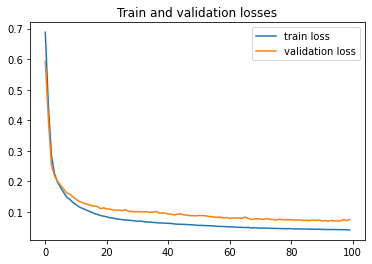

In [ ]:
plt.title('Train and validation losses')
plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(val_loss)), val_loss, label='validation loss')
plt.legend()
plt.show()

Save the trained model to a file.

In [ ]:
torch.save(model.state_dict(), 'model.pt')

Compute the loss on the test set.

In [ ]:
test_loss = evaluate(model, val_loader, device=DEVICE)
print(f'Test loss = {test_loss:.3f}')

loss = 0.057: 100%|██████████| 37/37 [00:00<00:00, 96.28it/s]

Test loss = 0.075


Now you will implement a `predict` function, which returns a `list` with the predictions of your model for each of the examples in the `data_loader`. This should be very similar to the `evaluate` function that you've written before, except that now there is no loss to be computed.

In [ ]:
def predict(model, data_loader, **kwargs):
    num_steps = kwargs.get('num_steps', 24)
    device = kwargs.get('device', torch.device('cpu'))
    
    model.eval()
    preds = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:
        ## YOUR CODE HERE ##
        batch["inputs"] = batch["inputs"].to(device)
        batch["targets"] = batch["targets"].to(device)
        num_steps = batch["targets"].shape[1] # batch_size, time, dim
        with torch.no_grad(): # no need to compute gradients
            batch_preds = model(batch["inputs"], num_steps)
        for pred in batch_preds: # store each prediction from batch
            preds.append(pred.cpu())
        ## *** ##
    return preds

In [ ]:
test_preds = predict(model, test_loader, num_steps=TARGET_WIDTH, device=DEVICE)

100%|██████████| 19/19 [00:00<00:00, 195.61it/s]


Finally, let's visualize a few predictions of our model. You can run the cell below multiple times to visualize the temperature predictions for different examples.

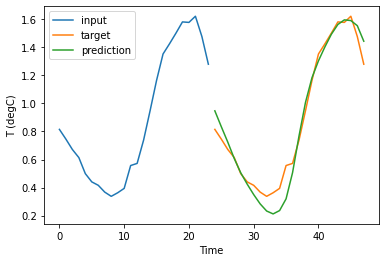

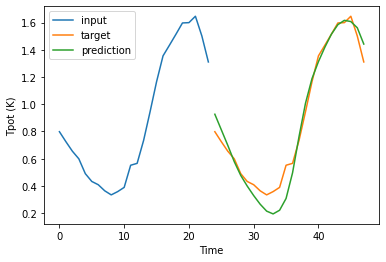

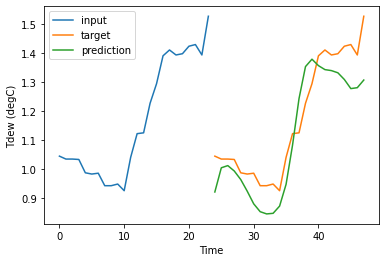

In [ ]:
idx = random.randint(0, len(test_data))
inputs = test_data[idx]['inputs'].numpy()
targets = test_data[idx]['targets'].numpy()
preds = test_preds[idx].numpy()

for i in [1, 2, 3]:
    plt.plot(range(INPUT_WIDTH), inputs[:,i], label='input')
    plt.plot(range(INPUT_WIDTH, INPUT_WIDTH + TARGET_WIDTH), targets[:,i], label='target')
    plt.plot(range(INPUT_WIDTH, INPUT_WIDTH + TARGET_WIDTH), preds[:,i], label='prediction')
    plt.ylabel(test_df.columns[i])
    plt.xlabel('Time')
    plt.legend()
    plt.show()

## Playground

Now, it's time for you to be creative! Try to find ways of improving the model. You can start by playing around with hyperparameters and then going for more complex stuff, like adding more layers or even trying with a different architecture. Perhaps, on this problem, a convolutional network works better than a recurrent one, who knows?

**Don't be afraid to try! Good luck! :)**